# Sample Elasticnet Regression

In [10]:
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from collections import OrderedDict

from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

sns.set(rc={'figure.figsize':(16.0,10.0)})
sns.set_style('white')

## Load Data

In [2]:
boston = datasets.load_boston(return_X_y=False)
data = pd.concat(
    [
        pd.DataFrame(boston.data, columns=boston.feature_names), 
        pd.Series(boston.target, name='MEDV')
    ], 
    axis=1
)
pd.concat([data.head(), data.tail()])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


## Feature Profiling

In [3]:
data.isnull().any().any()

False

In [4]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


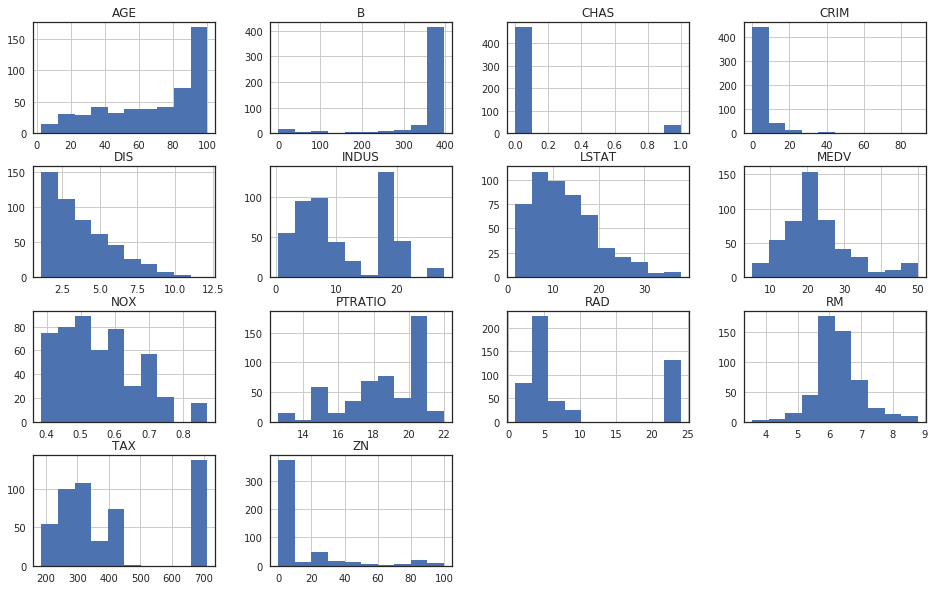

In [11]:
data.hist();

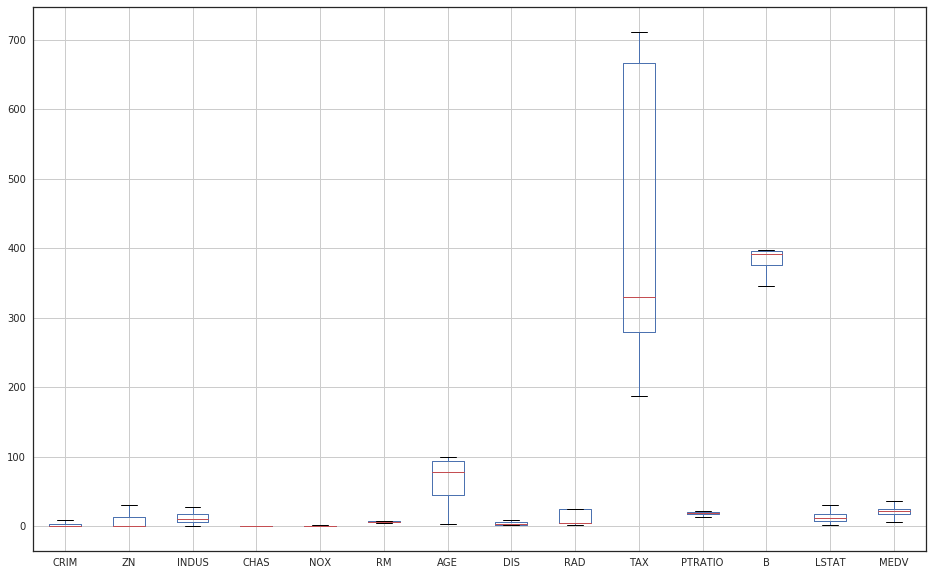

In [12]:
data.boxplot();

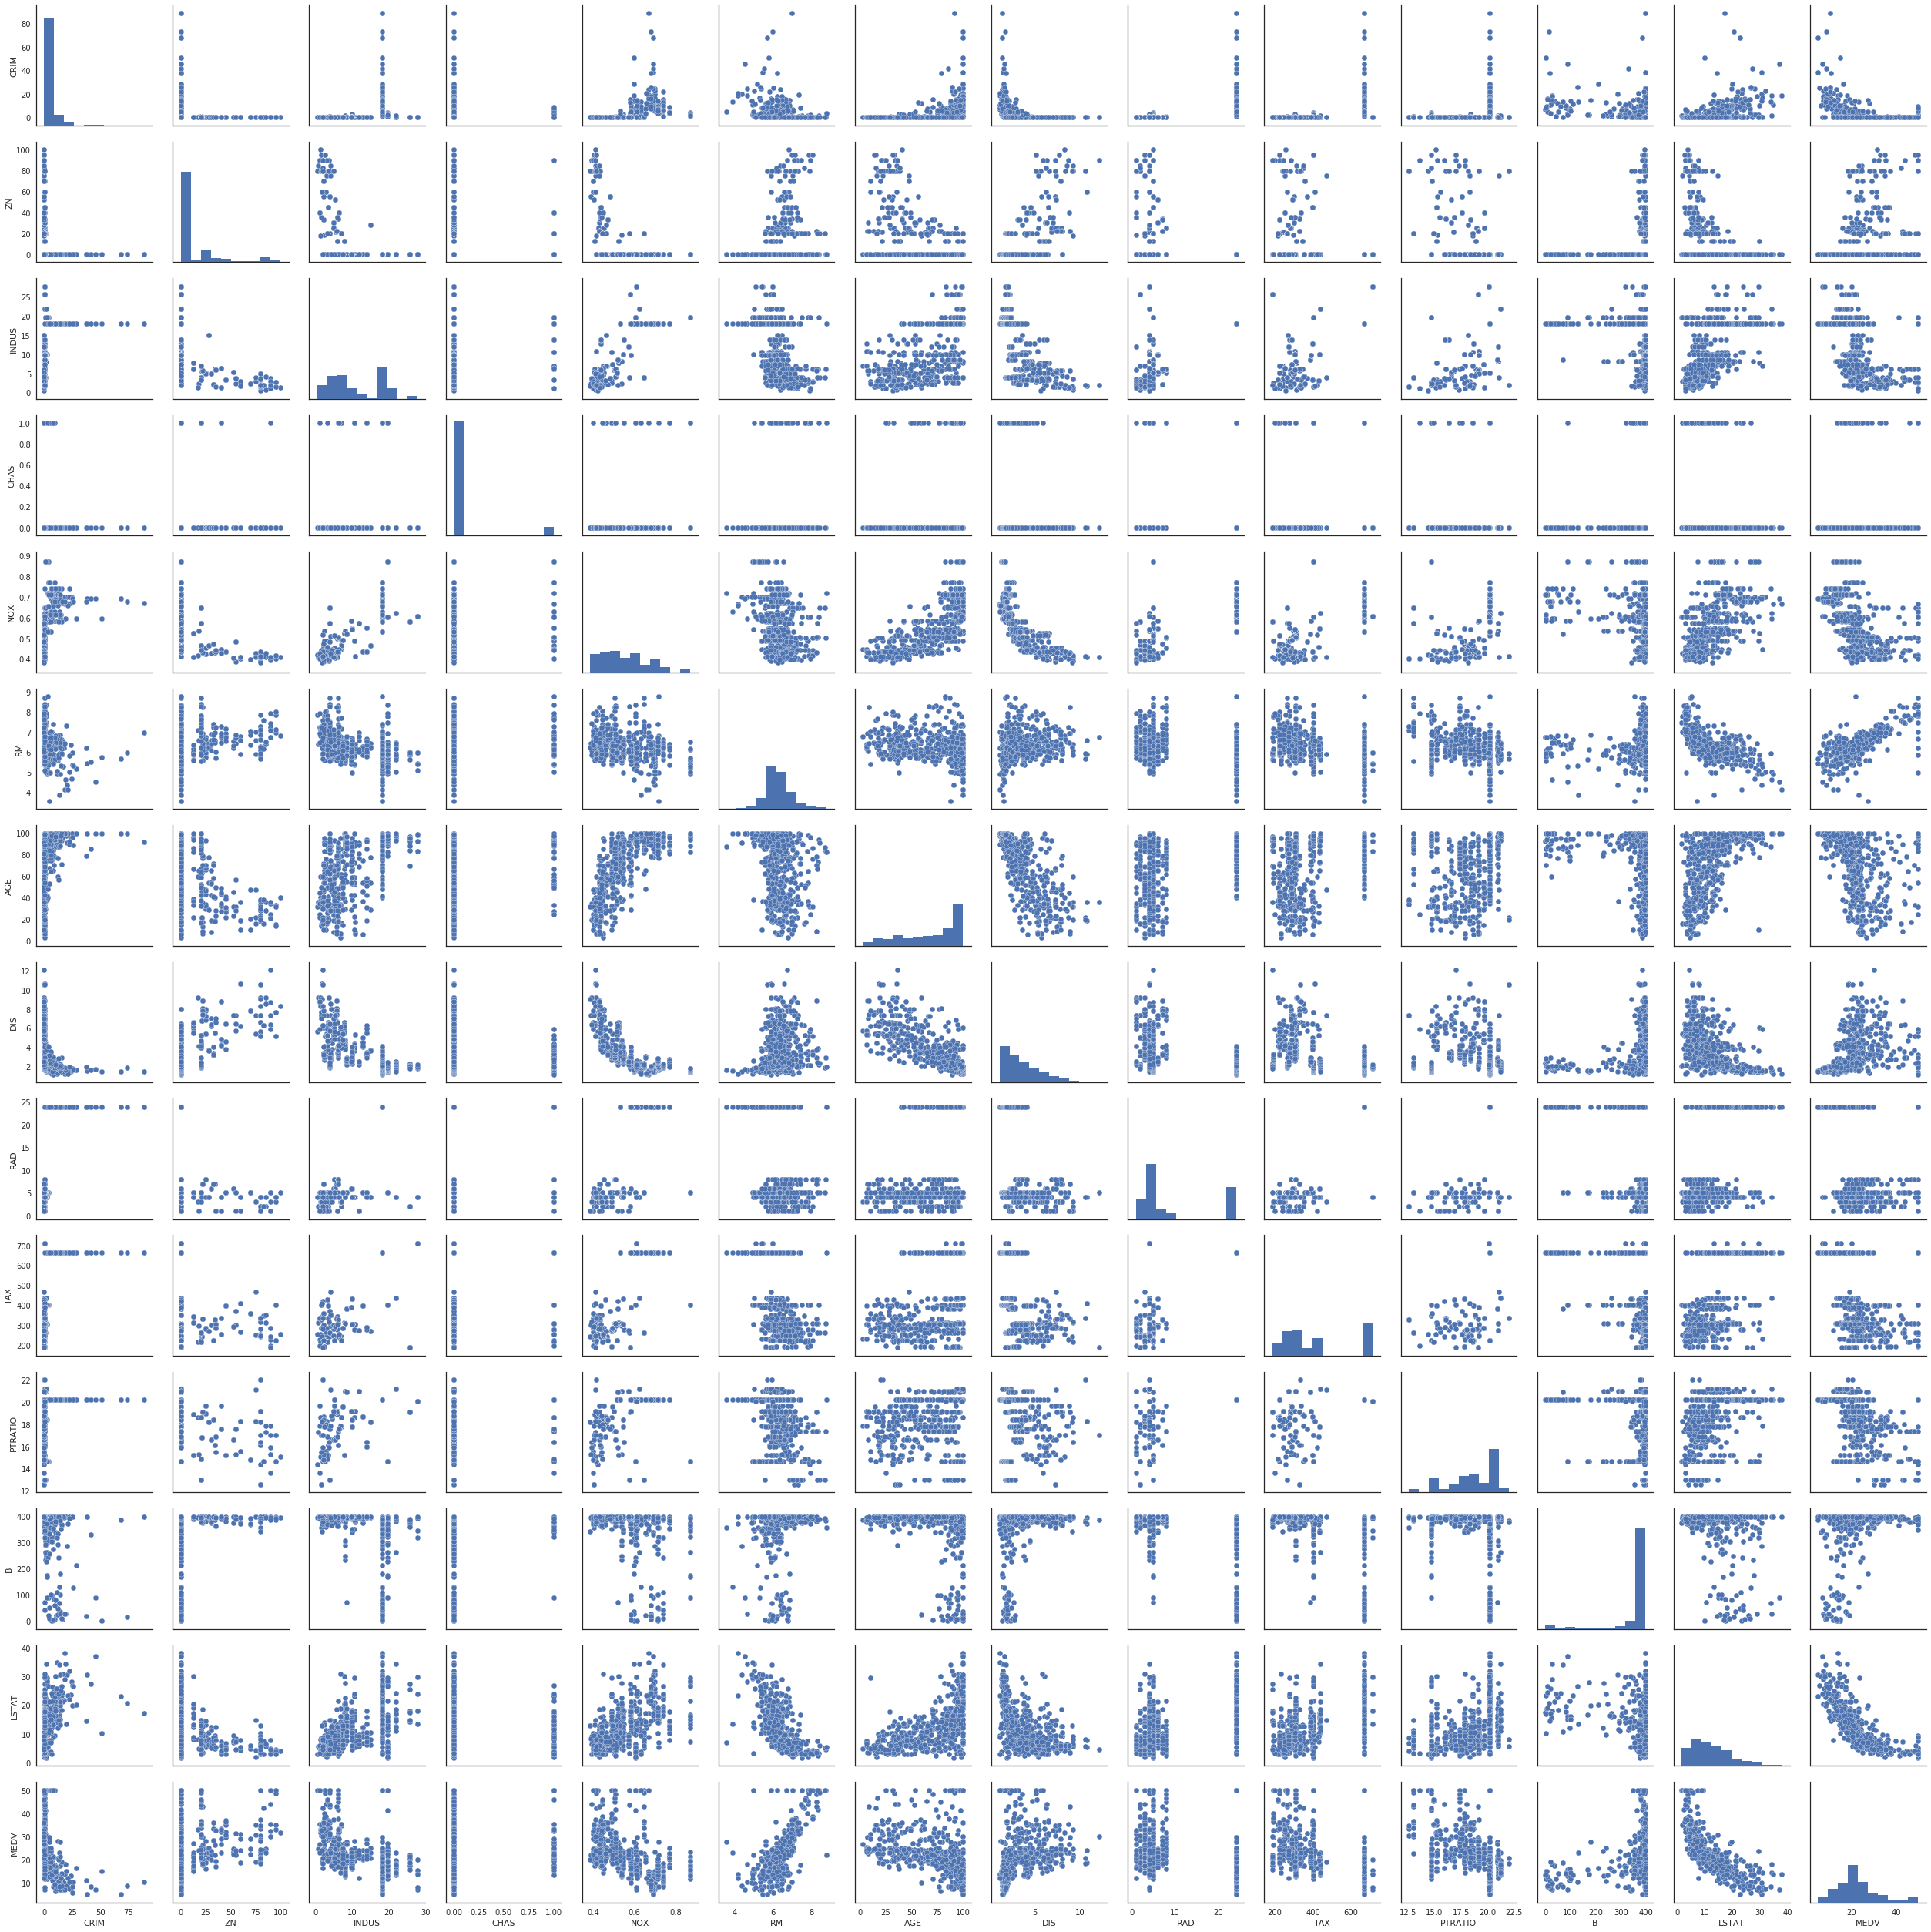

In [7]:
sns.pairplot(data)

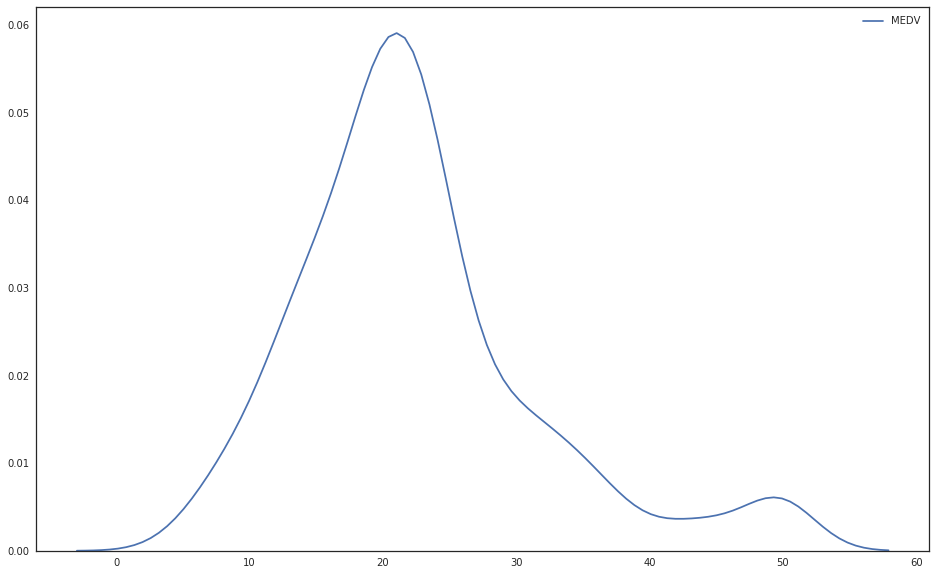

In [13]:
sns.kdeplot(data.MEDV)

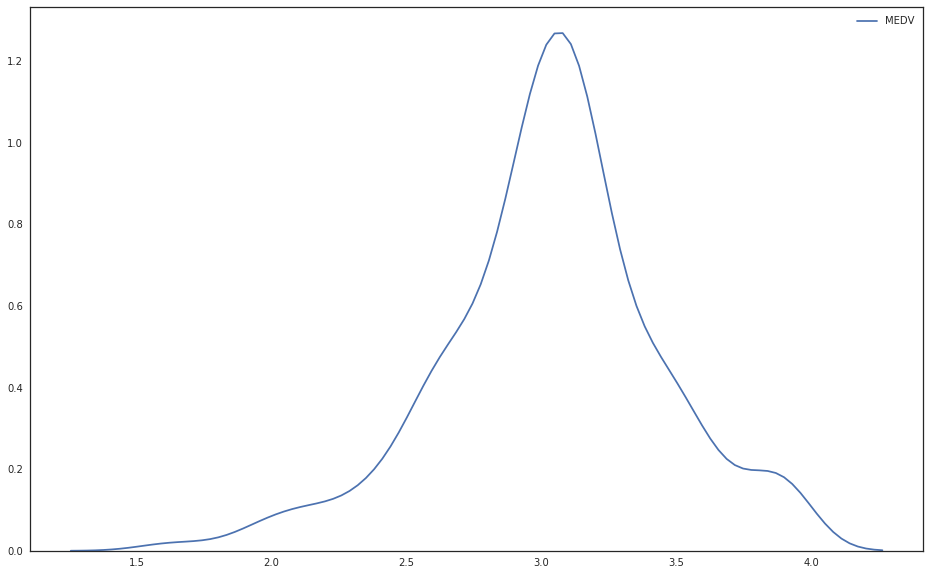

In [14]:
sns.kdeplot(np.log(data.MEDV))

CHAS
0.0    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
1.0    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
dtype: object

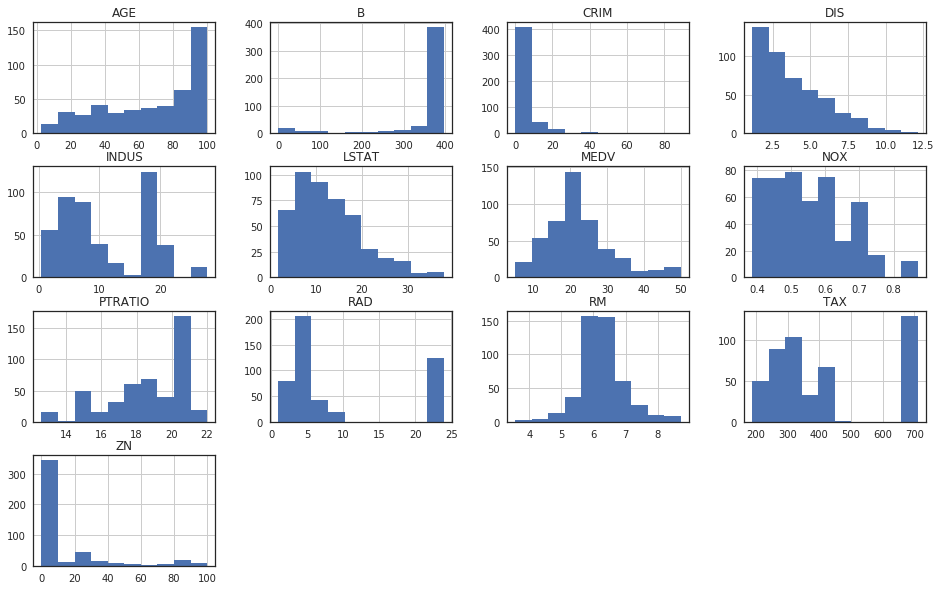

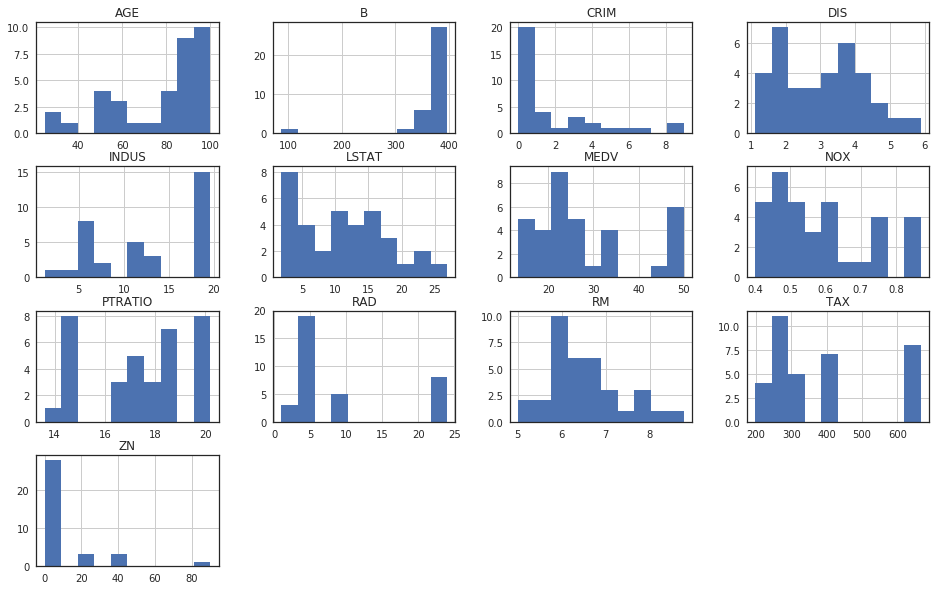

In [18]:
data.groupby('CHAS').hist()

## Feature Development

In [201]:
# Binning
data['age_bracket'] = pd.qcut(data.AGE, 10)
data['tax_bracket'] = pd.qcut(data.TAX, 5)

## Model Selection

In [202]:
formulae = [
    "MEDV ~ CRIM + INDUS + AGE",
    "MEDV ~ CRIM + INDUS + C(age_bracket)",
    "MEDV ~ -1 + tax_bracket:age_bracket",
]

In [203]:
models = [
    linear_model.ElasticNetCV(l1_ratio=0.5, n_alphas=100, cv=3, fit_intercept=True, normalize=True),
    linear_model.ElasticNetCV(l1_ratio=0.5, n_alphas=100, cv=5, fit_intercept=True, normalize=False),
]

In [204]:
# Define custom scorers
def mape_scorer(estimator, X, y):
    p = estimator.predict(X)
    perc_err = (y - p) / y
    abs_perc_err = np.abs(perc_err)
    return np.mean(abs_perc_err)

def rmse_scorer(estimator, X, y):
    p = estimator.predict(X)
    mse = mean_squared_error(y, p)
    return np.sqrt(mse)

In [205]:
results = pd.DataFrame()
for model_id, model in enumerate(models):
    for formula_id, formula in enumerate(formulae):
        
        (y, X) = patsy.dmatrices(formula, data)
        r2_scores = cross_val_score(model, X, y.ravel())
        rmse_scores = cross_val_score(model, X, y.ravel(), scoring=rmse_scorer)
        mape_scores = cross_val_score(model, X, y.ravel(), scoring=mape_scorer)
        
        result = pd.DataFrame(OrderedDict((
            ('model_id', model_id),
            ('model', str(model)),
            ('formula_id', formula_id),
            ('formula', formula),
            ('r2_score_mean', r2_scores.mean()),
            ('r2_score_stderr', r2_scores.std()),
            ('rmse_score_mean', rmse_scores.mean()),
            ('rmse_score_stderr', rmse_scores.std()),
            ('mape_score_mean', mape_scores.mean()),
            ('mape_score_stderr', mape_scores.std()),
        )), index=[0])
        results = pd.concat([results, result], axis=0, ignore_index=True)

results.sort_values(by='mape_score_mean', ascending=True)

,model_id,model,formula_id,formula,r2_score_mean,r2_score_stderr,rmse_score_mean,rmse_score_stderr,mape_score_mean,mape_score_stderr
0,0,"ElasticNetCV(alphas=None, copy_X=True, cv=3, e...",0,MEDV ~ CRIM + INDUS + AGE,-0.293270,0.192534,8.992976,1.182295,0.328331,0.118559
1,0,"ElasticNetCV(alphas=None, copy_X=True, cv=3, e...",1,MEDV ~ CRIM + INDUS + C(age_bracket),-0.352736,0.203887,9.205396,1.266411,0.345206,0.132077
3,1,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",0,MEDV ~ CRIM + INDUS + AGE,-0.335412,0.111501,9.132658,0.816971,0.348936,0.141302
4,1,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",1,MEDV ~ CRIM + INDUS + C(age_bracket),-0.328998,0.076553,9.121728,0.832597,0.354210,0.153242
2,0,"ElasticNetCV(alphas=None, copy_X=True, cv=3, e...",2,MEDV ~ -1 + tax_bracket:age_bracket,-0.672514,0.281124,10.268227,1.680302,0.420824,0.225316
5,1,"ElasticNetCV(alphas=None, copy_X=True, cv=5, e...",2,MEDV ~ -1 + tax_bracket:age_bracket,-0.670330,0.372505,10.256077,1.963500,0.424752,0.228172


## Model Profiling

- Print out the coefficients
- Predict predicted vs actual
- Plot one set of residuals against an unused variablem

### Extract Coefficients

In [213]:
best_model = MultiTaskElasticNetCV(cv=3, fit_intercept=True, l1_ratio=0.5, n_alphas=100, normalize=True)
best_formula = formulae[0]
(y, X) = patsy.dmatrices(best_formula, data, return_type="dataframe")
best_model.fit(X, y)

MultiTaskElasticNetCV(alphas=None, copy_X=True, cv=3, eps=0.001,
           fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
           n_jobs=1, normalize=True, random_state=None, selection='cyclic',
           tol=0.0001, verbose=0)

In [214]:
pd.DataFrame(list(zip(X.columns, best_model.coef_[0])))

,0,1
0,Intercept,0.000000
1,CRIM,-0.170644
2,INDUS,-0.285913
3,AGE,-0.036557


### Plot Fitted / Predicted vs Actuals

In [215]:
fitted = best_model.predict(X)
predicted = cross_val_predict(models[0], X, y.values.ravel(), cv=10)

In [216]:
def get_lims(ax):
    return [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

def set_lims(ax, lims, color):
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, color=color)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    return ax

def plot_fit_pred_actual(actual, fitted, predicted):
    
    plt.subplot(1, 2, 1)
    ax = sns.regplot(
        x=actual, 
        y=fitted,
    )
    ax.set_xlabel('Actual')
    ax.set_ylabel('Fitted')
    lims = get_lims(ax)
    set_lims(ax, lims, 'red')
    ax.set_title('Fitted vs Actual');

    plt.subplot(1, 2, 2)

    ax = sns.regplot(
        x=actual, 
        y=predicted,
        color='green',
    )
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    lims = get_lims(ax)
    set_lims(ax, lims, 'green')
    ax.set_title('Predicted vs Actual');

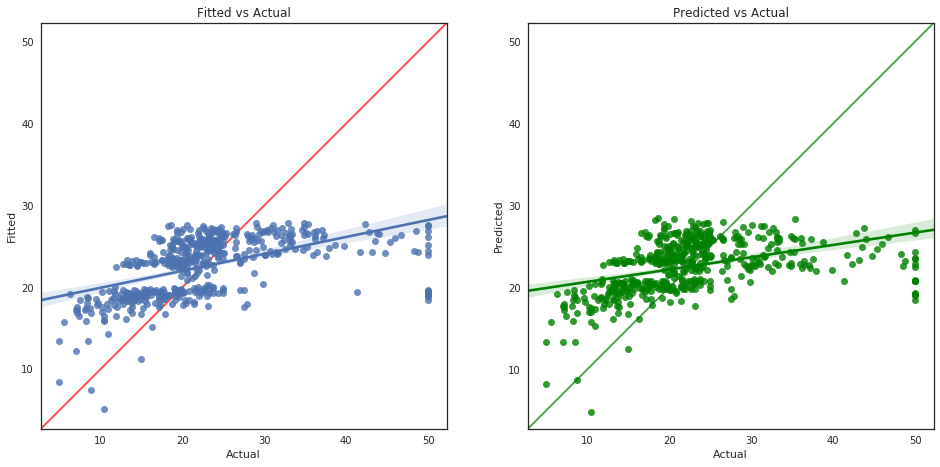

In [217]:
plot_fit_pred_actual(y.values.ravel(), fitted.flatten(), predicted.flatten())

### Plot Residuals

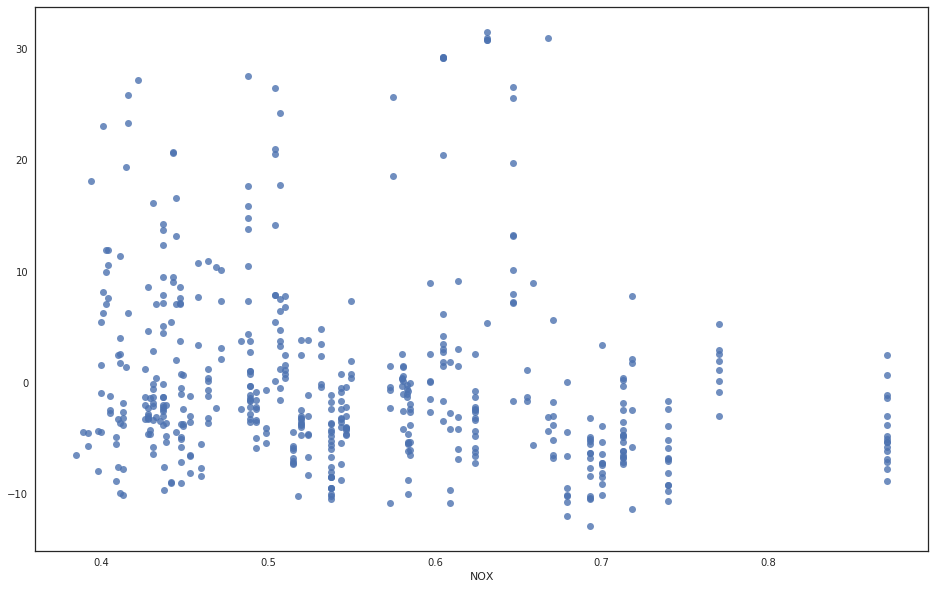

In [218]:
resid = y.values.ravel() - predicted.flatten()
sns.regplot(
    x=data.NOX, 
    y=resid,
    fit_reg=False
)